# Estimating a simpel model by simulated minimum distance (SMD)

**Inspiration:** This notebook is based on an example given by Julia/Economics ([link](https://juliaeconomics.com/tag/method-of-simulated-moments/)).

**MATLAB:** The file **SMD.mlx** contains a MATLAB version of the same notebook. 

* For a **guide to MATLAB for Python users** see [here](https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html).
* For **short course in MATLAB for economists** see [here](https://absalon.ku.dk/courses/25988/pages/online-matlab-course-for-students-of-economics) (the content is in the MATLAB_course folder). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import model

%load_ext autoreload
%autoreload 2

# The economic model

Let $c_i$ denote consumption and $0 \leq l_i \leq 1$ denote leisure. Consider an agent who wishes to maximize Cobb-Douglas utility over consumption and leisure subject to a budget constraint. That is

\\[
\max_{c_i,l_i} c_i^{\gamma}l_i^{1-\gamma} \\
\text{s.t.} \\
c_i \leq (1-\tau)w_i(1-l_i) + \epsilon_i
\\]

where $0 \leq \gamma \leq 1$ is the relative preference for consumption, $w_i$ is wage earned from supplying labor, \tau is the tax rate and \epsilon_i is a non-labor income shock.

This model has a closes form solution given by:

\\[
c^\star(w_i,\epsilon_i;\gamma) = \gamma(1-\tau)w_i+\gamma\epsilon_i \\
l^\star(w_i,\epsilon_i;\gamma) = (1-\gamma)+\frac{(1-\gamma)\epsilon_i}{(1-\tau)w_i}
\\]



# The empirical goal

We will impose a set of simplifying assumptions:

* The unobserved income shock is iid with known distribution, $\epsilon_i \sim N\left(0,\sigma {\;}^2 \right)$.
* The individual wages, $w_i$, are observed along with consumption and labor choices for $n=10,000$ individuals.

The goal is to estimate the relative preference for consumption and leisure, $\gamma \;$, and the tax rate, $\tau \;\;$ in this model. The set of parameters to be estimated thus is $\theta =\left(\gamma \;,\tau \;,\sigma \;\right)$.

To this end, we asume that we have a dataset consiting of ${\left\lbrace w_i ,c_i ,l_i \right\rbrace }_{i=1}^n$. To simulate such a dataset we run the following code. 

In [2]:
# a. true parameters in the data generating process
par = dict()
par['gamma'] = 0.5;
par['tau'] = 0.2;
par['sigma'] = 1.0;
true = par.copy()

# b. simulate observed dataset
np.random.seed(2019); # set the seed
n = 10000;

# stochastic variables
w = np.exp(np.random.normal(size=n)); # distribution of log-wages are (arbitrarely) chosen to be standard normal
e = par['sigma']*np.random.normal(size=n);

# optimal choices
con = model.c_star(w,e,par);
lab = model.l_star(w,e,par);

# Visualizing the data

We could imagine plotting the scatter of consumption and labor supply against wages. 

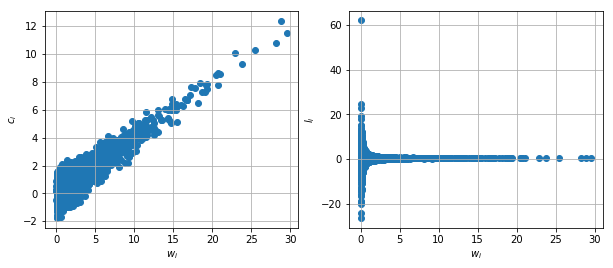

In [9]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(w,con)
ax.grid(True)
ax.set_xlabel('$w_i$')
ax.set_ylabel('$c_i$')

ax = fig.add_subplot(1,2,2)
ax.scatter(w,lab)
ax.grid(True)
ax.set_xlabel('$w_i$')
ax.set_ylabel('$l_i$');

We note that there is a clear relationship between consumption and wages. We could thus imagine estimating the two parameters in $\theta$ using the correlation between the consumption and wages, the average labor supply and the variance of consumption. 

# Identification

From the solution we note that the correlation between wages and consumption depends on $\gamma$ and $\tau$, the mean of the labor supply should be $1-\gamma \;$ and that the variance of consumption should be proportional to the variance of $\epsilon$, $\sigma^2$. These moments, in turn, should be able to identify the parameters in $\theta$.

We can denote the moments in the data as $\Lambda^{\mathrm{data}} ={\left(\mathrm{corr}\left(w_i ,c_i \right),\mathrm{mean}\left(l_i \right),\mathrm{var}\left(c_i \right)\right)}^{\prime }$ and calculate them as:

In [4]:
moments_fun = lambda w,con,lab: np.array([np.corrcoef(w,con)[0,1], np.mean(lab), np.var(con)])
mom_data = moments_fun(w,con,lab)
print(mom_data)

[0.85215649 0.4987026  0.92769402]


# A SMD Estimator

We can then estimate $\theta$ by minimizing the squared distance between the empirical moments in the data, $\Lambda^{\mathrm{data}}$, and the same moments calculated from $S=100$ *simulated* agents for each of the $n$ values of $w_i$ from the model for each guess of $\theta$, $\Lambda^{\mathrm{sim}} \left(\theta;w\right)$. 

Concretely, we simulate draws of ${\left\lbrace \epsilon {{\;}_i }^{\left(s\right)} \right\rbrace}_{i=1,s=1}^{n,S}$, calculate the synthetic dataset for a value of $\theta$, ${\left\lbrace w_i ,c_i^{\left(s\right)} {,l}_i^{\left(s\right)} \right\rbrace }_{i=1,s=1}^{n,s}$, and stack these $n\times S$ observations to calculate the moments above to get $\Lambda^{\textrm{sim}} \left(\theta;w\right)$.

Our **SMD estimator** is     

\\[ \hat{\theta} = \arg \min_\theta Q(\theta;w) \\]

where the objective function is $Q(\theta;w)=(\Lambda^{data}-\Lambda^{sim}(\theta;w))'(\Lambda^{data}-\Lambda^{sim}(\theta,w)) $.

The objective function could be coded as done in the ``model.obj_fun()``. In the model.py file.

# Objective function

We specify which parameters to be estimated and construct initial starting values as

In [5]:
est_par = ['gamma','tau','sigma'] # parameters to estimate
theta0 = [0.4,0.15,0.9]  # initial guesses

And we can evaluate the objective function as

In [6]:
obj_at_theta0 = model.obj_fun(theta0,est_par,w,mom_data,moments_fun,par)
print(obj_at_theta0)

0.10917348811846349


# Call optimizer

We then call an unconstained optimizer using numerical gradients with option to print iterations

In [7]:
obj_fun = lambda theta: model.obj_fun(theta,est_par,w,mom_data,moments_fun,par)

results = optimize.minimize(obj_fun,theta0,options={'disp':True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 65
         Gradient evaluations: 13


In [8]:
print(f'{"":7s}{"True":>7s}{"Est.":>7s}')
for name,value in zip(est_par,results.x):
    print(f'{name:7s}{true[name]:7.3f}{value:7.3f}')

          True   Est.
gamma    0.500  0.499
tau      0.200  0.198
sigma    1.000  1.009
